In [1]:
import pandas as pd
from utils import database as db

In [2]:
players = pd.read_csv("data/0-1-IneriaRanks.csv")
players=players.set_index(players.columns[0])
pairs = pd.read_csv("data/0-1-PlayerPairs.csv")
pairs.head()

,Unnamed: 0,player1,player2
0,0,Carlos Alcaraz,Nicolas Jarry
1,1,Alexander Zverev,Matteo Berrettini
2,2,Frances Tiafoe,Grigor Dimitrov
3,3,Alejandro Davidovich Fokina,Holger Rune
4,4,Daniil Medvedev,Marton Fucsovics


In [3]:
_dictionary = pd.read_csv("data_dictionary.csv")
_data = pd.read_csv("Wimbledon_featured_matches.csv")

In [4]:
dictionary = _dictionary.copy()
data = _data.copy()
data.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN


# Data Pre-processing for Training

## Laybel Encoding for the scores

$$
{\cal F}:  \{0,15,30,40,AD\}\mapsto \{0,1,2,3,4\}
$$

In [5]:
print(data.columns)
data["p1_score"].drop_duplicates()

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score',
       'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'winner_shot_type', 'p1_double_fault',
       'p2_double_fault', 'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt',
       'p1_net_pt_won', 'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt',
       'p1_break_pt_won', 'p2_break_pt_won', 'p1_break_pt_missed',
       'p2_break_pt_missed', 'p1_distance_run', 'p2_distance_run',
       'rally_count', 'speed_mph', 'serve_width', 'serve_depth',
       'return_depth'],
      dtype='object')


0        0
2       15
4       30
5       40
7       AD
143      1
144      2
147      3
148      4
151      5
152      6
966      7
967      8
1503     9
Name: p1_score, dtype: object

In [6]:
maps = {
    "0":0,
    "15":1,
    "30":2,
    "40":3,
    "AD":4,

    "0":0,
    "1":1,
    "2":2,
    "3":3,
    "4":4,
    "5":5,
    "6":6,
    "7":7,
    "8":8,
    "9":9,

    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9
}

In [7]:
data["p1_score"] = data["p1_score"].map(maps)
data["p2_score"] = data["p2_score"].map(maps)
data["p1_score"].drop_duplicates()

0       0
2       1
4       2
5       3
7       4
151     5
152     6
966     7
967     8
1503    9
Name: p1_score, dtype: int64

## Normalization for running distance & rally count

$$
{\cal F}:  \Bbb R^+\mapsto \Bbb R^+
$$

$$
\Bbb E[{\cal F}]\approx 0,~\Bbb V[{\cal F}]\approx 1
$$

In [8]:
data_norm = data.copy()

- firstly analyze the distribution of running distance

In [9]:
running_dist = data["p1_distance_run"]._append(data["p2_distance_run"])
#running_dist = running_dist[running_dist>2]
running_dist

0        6.000
1        5.253
2       13.800
3       51.108
4        0.649
         ...  
7279    50.971
7280    27.766
7281    18.328
7282    10.537
7283    25.367
Length: 14568, dtype: float64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import visualize as vs
sns.set_style("darkgrid")

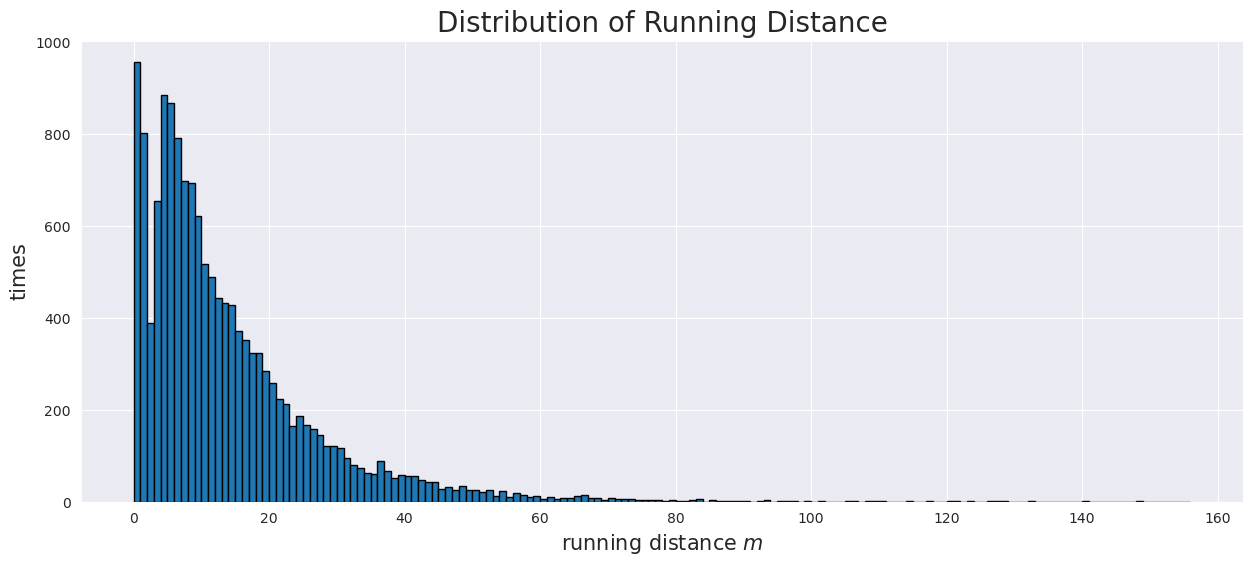

In [11]:
plt.figure(figsize=(15, 6))
plt.hist(running_dist, bins=range(int(running_dist.min()), int(running_dist.max()) + 1), edgecolor='black')

vs.set_label("Distribution of Running Distance", r"running distance $m$", "times")

vs.save("3-1-DistribOfRunningDist")
plt.show()

In [12]:
from scipy.stats import gamma
from scipy.stats import expon
import numpy as np

In [13]:
std = np.std(running_dist)

fit_params = gamma.fit(running_dist)
fit_params

(1.1512694169681708, -0.01393912167011625, 12.116759998946346)

In [14]:
x = np.linspace(0, 150, 600)
xs = np.linspace(0, 150/std, 600)
p = gamma.pdf(x, *fit_params)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


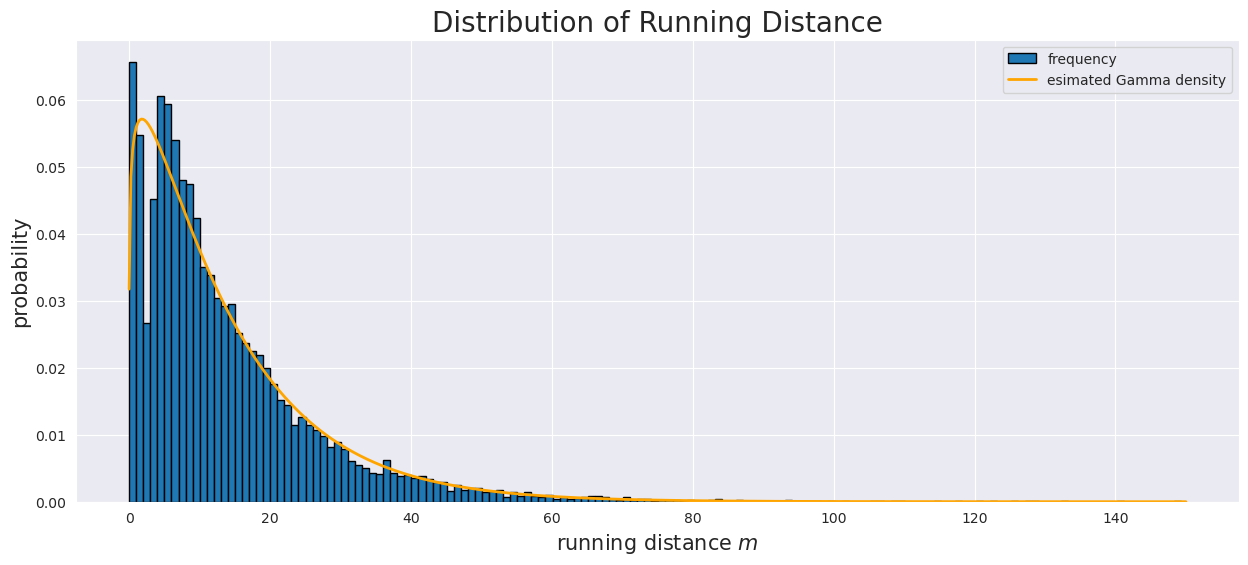

In [15]:
plt.figure(figsize=(15, 6))

plt.hist(running_dist, bins=x[::4], density=True, edgecolor='black', label = "frequency")
plt.plot(x, p, 'orange', linewidth=2, label = "esimated Gamma density")
#plt.plot(x, p, 'k', linewidth=2, label = "esimated Gamma")
plt.legend()

vs.set_label("Distribution of Running Distance", r"running distance $m$", "probability")

vs.save("3-1-DistribOfRunningDist")
plt.show()

$$
p(x,\alpha,\beta)={\beta^{-\alpha}\over \Gamma(\alpha)}x^{\alpha-1}e^{-x/\beta}
$$

$$
\alpha=1.1555147307135378,~\beta=12.129877151688223,~\sigma = \sqrt{\alpha}\beta=13.038995805596418
$$

In [16]:
a, _, b = fit_params
#nor = np.sqrt(a)*b
nor = 2*a*b

In [17]:
np.mean(running_dist/nor)

0.49950248338300485

In [18]:
data_norm["p1_distance_run"] = data["p1_distance_run"]/nor
data_norm["p2_distance_run"] = data["p2_distance_run"]/nor

- secondly, analyze the distribution of rally count

In [19]:
rc = data["rally_count"]

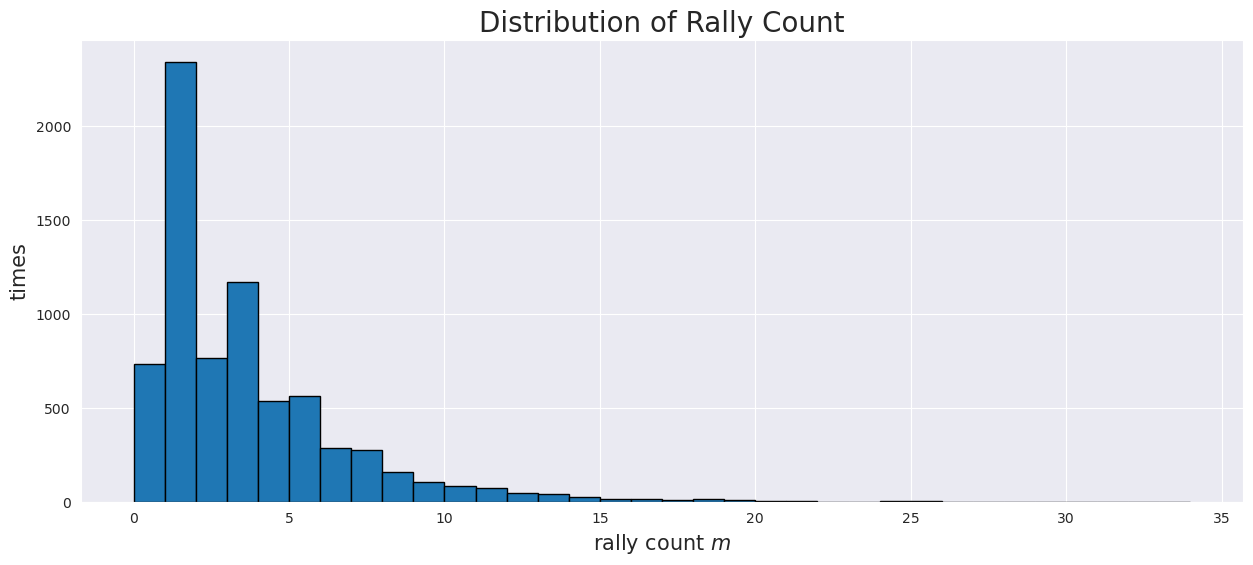

In [20]:
plt.figure(figsize=(15, 6))
plt.hist(rc, bins=range(int(rc.min()), int(rc.max()) + 1), edgecolor='black')

vs.set_label("Distribution of Rally Count", r"rally count $m$", "times")

vs.save("3-1-DistribOfRallyCount")
plt.show()

In [21]:
fit_params = gamma.fit(rc)
fit_params

x = np.linspace(0.4, 35, 600)
p = gamma.pdf(x, *fit_params)
fit_params

(0.8857051454816715, -3.0171772197565623e-22, 2.794643555513843)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


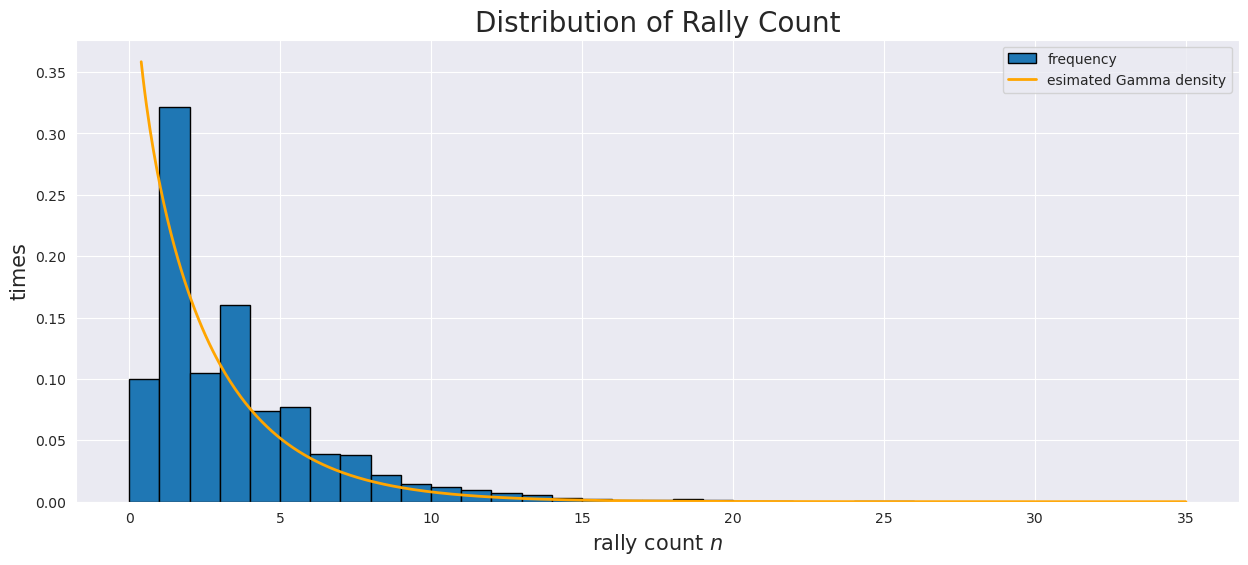

In [22]:
plt.figure(figsize=(15, 6))

plt.hist(rc, bins=range(0,35), density=True, edgecolor='black', label = "frequency")
plt.plot(x, p, 'orange', linewidth=2, label = "esimated Gamma density")
#plt.plot(x, p, 'k', linewidth=2, label = "esimated Gamma")
plt.legend()

vs.set_label("Distribution of Rally Count", r"rally count $n$", "times")

vs.save("3-1-DistribOfRallyCount")
plt.show()

In [23]:
a, _, b = fit_params
#nor = np.sqrt(a)*b
nor = 2*a*b

In [24]:
data_norm["rally_count"] = data["rally_count"]/nor
data_norm.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,0.215059,0.281011,0.404003,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,0.188284,0.254272,0.202001,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,0.494636,0.709982,0.808006,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,1.831873,2.710856,2.626018,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.023262,0.029141,0.202001,112.0,W,NCTL,NaN


# Model Training

In [25]:
from utils import database as db
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [26]:
eg1 = db.select_match_norm(data_norm, "Carlos Alcaraz", "Nicolas Jarry")

## Filtering with geometric kernel

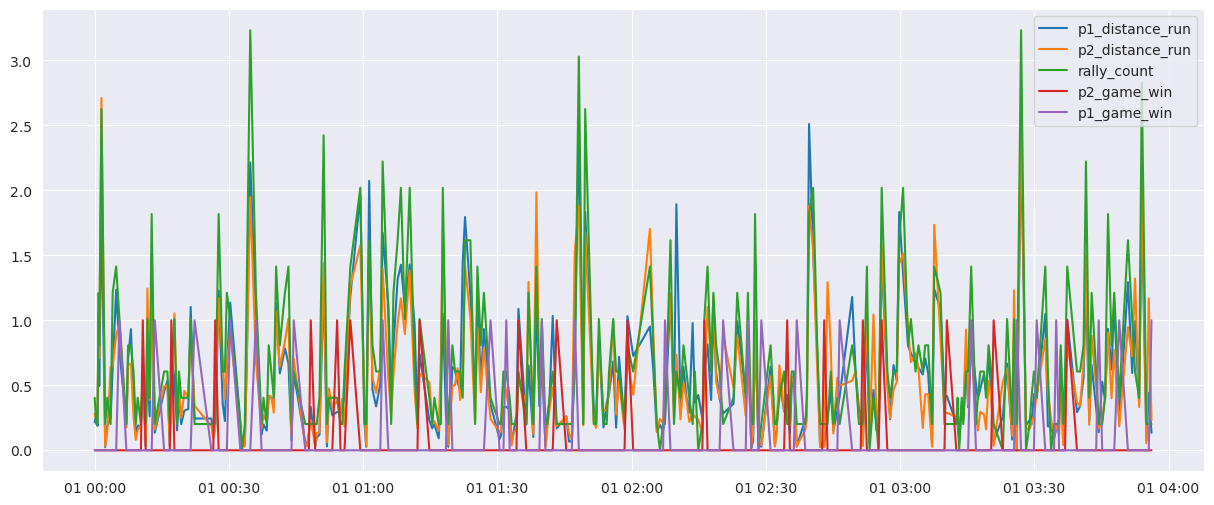

In [27]:
inputs = ["p1_distance_run","p2_distance_run", "rally_count", 'p2_game_win', 'p1_game_win']

plt.figure(figsize=(15, 6))

plt.plot(eg1[inputs], label = inputs)
plt.legend()

In [28]:
for tar in inputs:
    tar_ser = eg1[tar]
    tar_ser = db.expected_P(tar_ser, 0.5, 30)
    eg1[tar] = tar_ser.values

eg1[inputs]

,p1_distance_run,p2_distance_run,rally_count,p2_game_win,p1_game_win
elapsed_time,,,,,
1900-01-01 00:00:00,0.215059,0.281011,0.404003,0.000000e+00,0.000000
1900-01-01 00:00:22,0.247479,0.250006,0.303002,0.000000e+00,0.000000
1900-01-01 00:00:38,0.217882,0.252139,0.252502,0.000000e+00,0.000000
1900-01-01 00:00:53,0.630352,0.656423,0.732255,0.000000e+00,0.000000
1900-01-01 00:01:01,0.562494,0.683202,0.770130,0.000000e+00,0.000000
...,...,...,...,...,...
1900-01-01 03:53:25,0.618653,0.671990,0.627227,1.907349e-06,0.031738
1900-01-01 03:54:01,1.246948,1.388404,1.727623,9.536743e-07,0.015869
1900-01-01 03:55:02,0.660321,0.721246,0.964812,4.768372e-07,0.007935


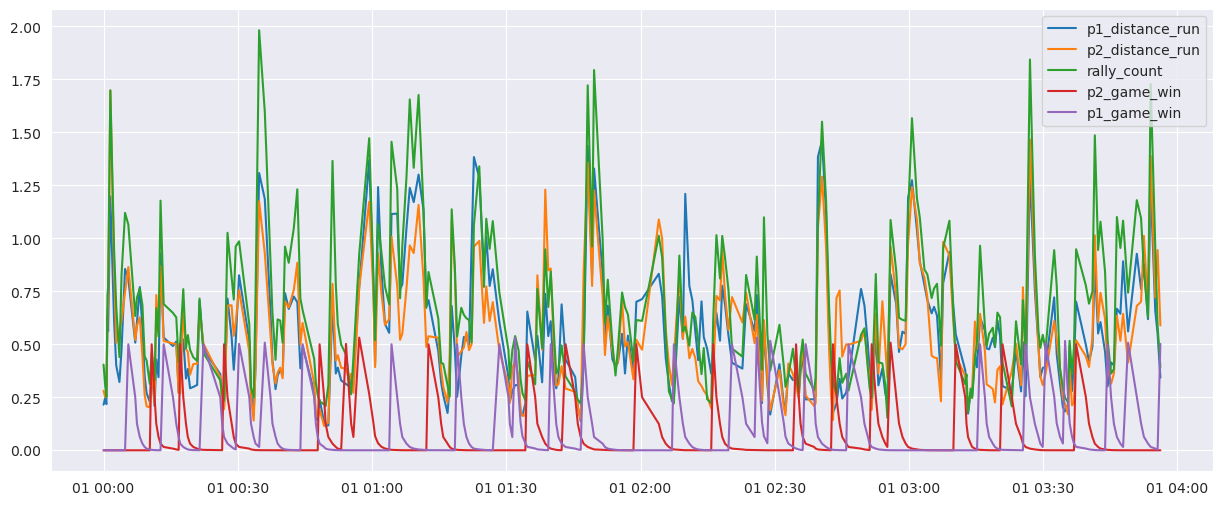

In [29]:
plt.figure(figsize=(15, 6))

plt.plot(eg1[inputs], label = inputs)
plt.legend()

## Calculate Turque Pulse

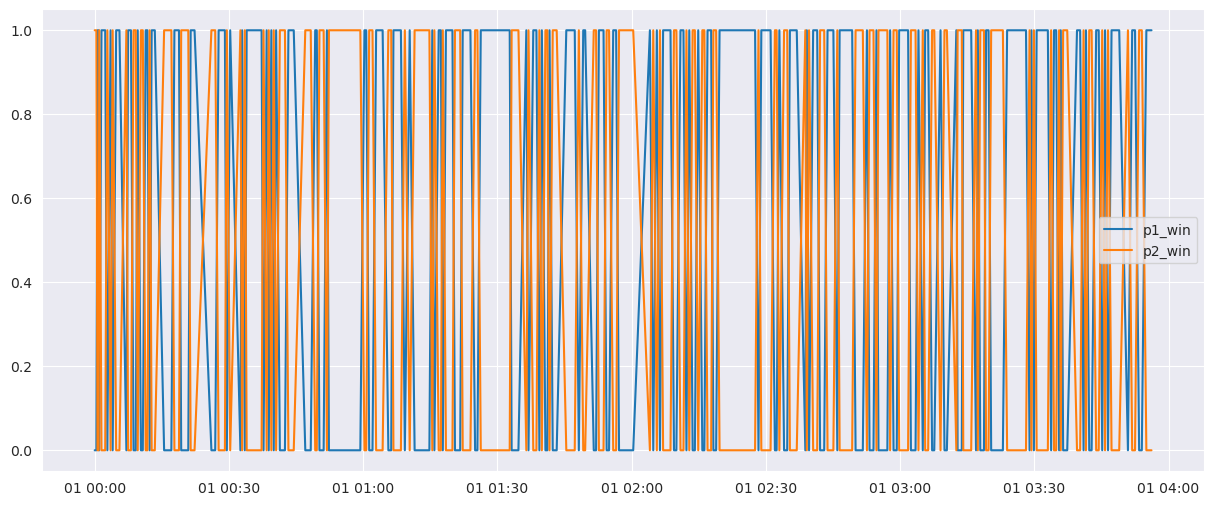

In [30]:
wins = ['p1_win', 'p2_win']

plt.figure(figsize=(15, 6))

plt.plot(eg1[wins], label = wins)
plt.legend()

In [31]:
for tar in wins:
    tar_ser = eg1[tar]
    tar_ser = db.expected_P(tar_ser, 0.2, 30)
    eg1[tar] = tar_ser.values

eg1[wins]

,p1_win,p2_win
elapsed_time,,
1900-01-01 00:00:00,0.000000,1.000000
1900-01-01 00:00:22,0.000000,1.000000
1900-01-01 00:00:38,0.200000,0.800000
1900-01-01 00:00:53,0.360000,0.640000
1900-01-01 00:01:01,0.288000,0.712000
...,...,...
1900-01-01 03:53:25,0.584468,0.415532
1900-01-01 03:54:01,0.468812,0.531188
1900-01-01 03:55:02,0.575050,0.424950


In [32]:
I1 = players["Inertia"]["Carlos Alcaraz"]
I2 = players["Inertia"]["Nicolas Jarry"]

In [33]:
w1, w2 = db.get_velocity(eg1[wins[0]], I1, I2)
L1, L2 = I1*w1, I2*w2
DL1, DL2 = L1.diff().fillna(0), L2.diff().fillna(0)
Dt = DL1.index.diff().fillna(pd.to_timedelta("00:01:00"))
#Dt = db.to_minute(Dt)
Dt = Dt.to_series().apply(lambda x: x.total_seconds() / 60).values

T1, T2 = DL1/Dt, DL2/Dt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


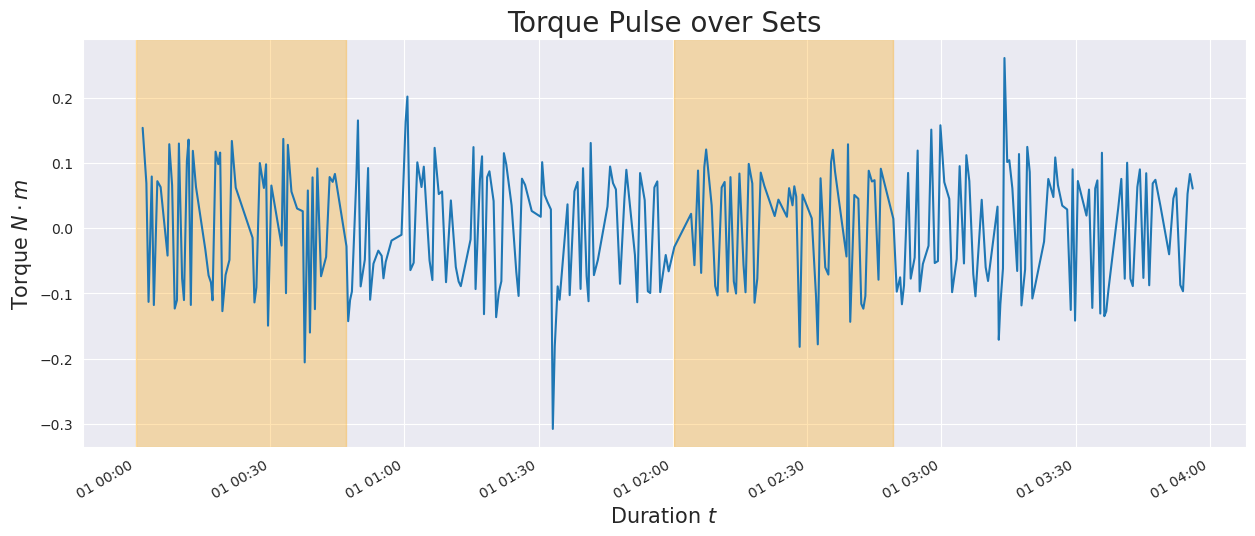

In [36]:
plt.figure(figsize=(15, 6))

T1[5:].plot()

set_range = db.get_set_range(eg1)
vs.draw_range(set_range)

vs.set_label("Torque Pulse over Sets", r"Duration $t$", r"Torque $N\cdot m$")
vs.save("3-2-TorquePulse")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


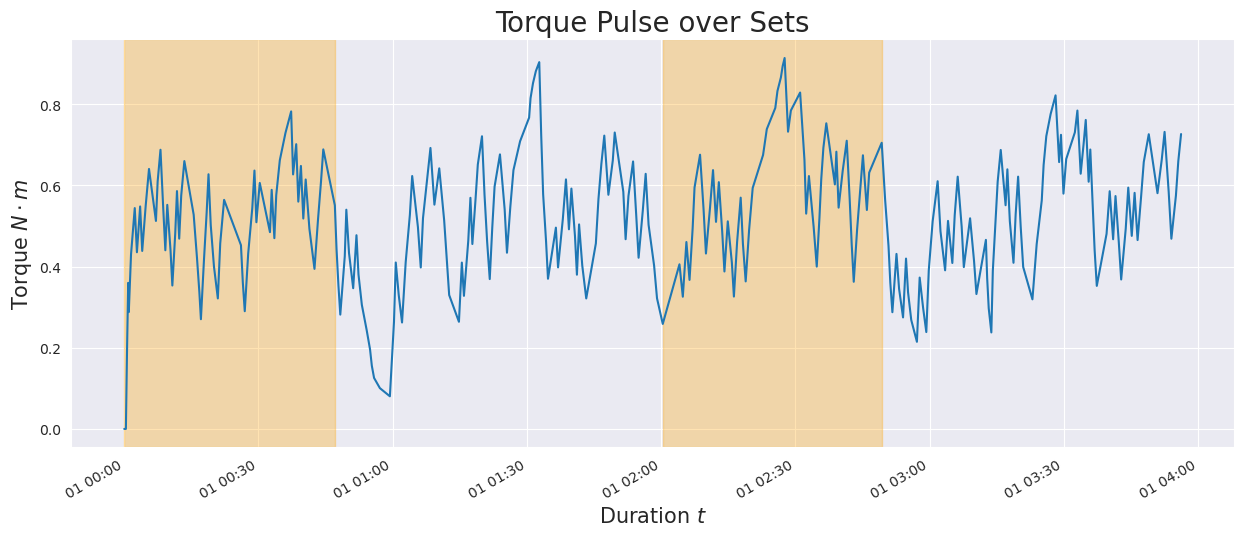

In [39]:
plt.figure(figsize=(15, 6))

eg1[wins[0]].plot()

set_range = db.get_set_range(eg1)
vs.draw_range(set_range)

vs.set_label("Filtered Winning Rate", r"Duration $t$", r"Winning Rate")
vs.save("3-2-FilteredWinningRate")

plt.show()